In [1]:
!pip install pyreadstat #Instalamos la librería necesaria 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 31.6 MB/s 


In [2]:
import pyreadstat # importar archivos en formato .SAV (SPSS)
import pandas as pd # Manipulación de datos
import seaborn as sns # Graficos
import numpy as np
import statsmodels.api as sm # Este proporciona funciones para la estimación de muchos modelos estadísticos
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive # Ocupar y obtener los datos desde nuestro Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargamos nuestros datos a ocupar (CASEN 2017)

In [4]:
casen, meta = pyreadstat.read_sav("/content/drive/MyDrive/Colab Notebooks/Casen 2017.sav", apply_value_formats = True)

## Revisión basica de los datos a trabajar

In [5]:
casen.head()

,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1.0,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1.0,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pobre,Pobre
2,1.101100e+11,1.0,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
3,1.101100e+11,2.0,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
4,1.101100e+11,1.0,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,No pobre,NaN


In [6]:
casen.shape

(216439, 804)

In [7]:
casen.isnull().sum()

folio                  0
o                      0
id_vivienda            0
hogar                  0
region                 0
                    ... 
hh_d_appart         1276
hh_d_tsocial         208
hh_d_seg             208
pobreza_multi_4d    8643
pobreza_multi_5d    9867
Length: 804, dtype: int64

## Crearemos un DF que contenga el nombre de la columnas, su etiqueta (pregunta) y el tipo de dato que tiene

In [8]:
etiquetas = pd.DataFrame(list((meta.column_names_to_labels).items()), columns=['Columna', 'Etiqueta'])

tipos= pd.DataFrame(casen.dtypes, columns= ['Tipos'])
tipos['Columna'] = tipos.index
tipos= tipos.reset_index(drop= True)

dicc_datos= pd.merge(etiquetas, tipos, on= 'Columna')
dicc_datos

,Columna,Etiqueta,Tipos
0,folio,Identificación hogar (comuna area seg viv hogar),float64
1,o,Orden,float64
2,id_vivienda,Identificador de la vivienda (comuna area seg ...,float64
3,hogar,Identificación del hogar en la vivienda,float64
4,region,Región,category
...,...,...,...
799,hh_d_appart,Hogar carente en apoyo y participación social,float64
800,hh_d_tsocial,Hogar carente en trato igualitario,float64
801,hh_d_seg,Hogar carente en seguridad,float64
802,pobreza_multi_4d,Situación de pobreza multidimensional (4 dimen...,category


## Seleccionaremos variables relevantes para hacer nuestro análisis de regresión

In [9]:
#Disminuiremos el tamaño de nuestro DF para ahorrar recursos computacionales, 
# Las variables que seleccionaremos serán solamente las que utilizaremos en nuestro ejercicio

# Ingresos del trabajador
# Años de escolaridad 
# Rama de actividad economica
# Oficio
# Region
# Sexo
# Zona
# Edad
# Condicion de actividad economica
datos= casen[['ytrabajocor','esc','rama1','oficio1','region','zona','sexo','edad','activ']]

In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216439 entries, 0 to 216438
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ytrabajocor  97235 non-null   float64 
 1   esc          174058 non-null  float64 
 2   rama1        92417 non-null   category
 3   oficio1      92417 non-null   category
 4   region       216439 non-null  category
 5   zona         216439 non-null  category
 6   sexo         216439 non-null  category
 7   edad         216439 non-null  float64 
 8   activ        175076 non-null  category
dtypes: category(6), float64(3)
memory usage: 6.2 MB


In [11]:
pd.crosstab(index= datos['region'], columns=['N'])

col_0,N
region,
Región Metropolitana de Santiago,42601
Región de Antofagasta,8510
Región de Arica y Parinacota,7888
Región de Atacama,6961
Región de Ayséndel Gral. Carlos Ibáñez del Campo,5045
Región de Coquimbo,9952
Región de La Araucanía,15481
Región de Los Lagos,12442
Región de Los Ríos,10175


In [12]:
pd.crosstab(index= datos['activ'], columns=['N'])

col_0,N
activ,
Desocupados,7803
Inactivos,74856
Ocupados,92417


In [13]:
#Filtramos a las personas ocupadas (laboralmente)
datos= datos[datos.activ== "Ocupados"]
pd.crosstab(index= datos['activ'], columns=['N'])

#Borramos columna activ

datos= datos.drop(columns=['activ'])

datos= datos.dropna()

datos

,ytrabajocor,esc,rama1,oficio1,region,zona,sexo,edad
0,250000.0,12.0,Comercio al por mayor y al por menor,Trabajadores no calificado,Región de Tarapacá,Urbano,Mujer,56.0
1,200000.0,7.0,Hogares privados con servicio doméstico,Trabajadores no calificado,Región de Tarapacá,Urbano,Mujer,21.0
2,281750.0,12.0,Hoteles y restaurantes,Trabajadores de los servicios y vendedores de ...,Región de Tarapacá,Urbano,Hombre,24.0
3,311750.0,12.0,Hoteles y restaurantes,Trabajadores de los servicios y vendedores de ...,Región de Tarapacá,Urbano,Hombre,28.0
4,341667.0,15.0,Hogares privados con servicio doméstico,Trabajadores no calificado,Región de Tarapacá,Urbano,Hombre,26.0
...,...,...,...,...,...,...,...,...
216428,562500.0,8.0,"Agricultura, ganadería, caza y silvicultura",Agricultores y trabajadores calificados agrope...,Región de Arica y Parinacota,Rural,Hombre,40.0
216429,150000.0,8.0,"Otras actividades de servicios comunitarios, s...",Trabajadores no calificado,Región de Arica y Parinacota,Rural,Mujer,40.0
216435,200000.0,4.0,Construcción,Trabajadores no calificado,Región de Arica y Parinacota,Rural,Hombre,64.0
216437,250000.0,3.0,"Agricultura, ganadería, caza y silvicultura",Agricultores y trabajadores calificados agrope...,Región de Arica y Parinacota,Rural,Mujer,60.0


## Como estudio explotario SIEMPRE debemos ver la relación entre nuestros datos de interes, además nos sirve para el modelo de Regresión Lineal

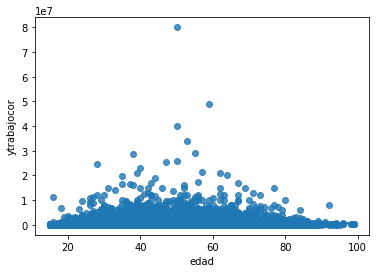

In [14]:
## el nivel que se nos presentan los datos esta a nivel de 10 (8 es 80)
sns.regplot(x="edad", y="ytrabajocor", data=datos);
## Ojo que hay una recta, esta "escondida" pero si aparece

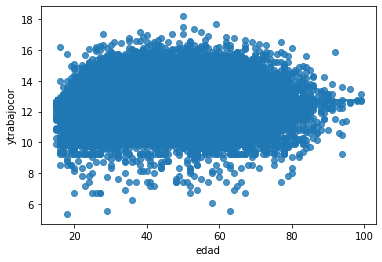

In [15]:
#Función Logaritmica 
sns.regplot(y= np.log(datos['ytrabajocor']), x=datos['edad'])

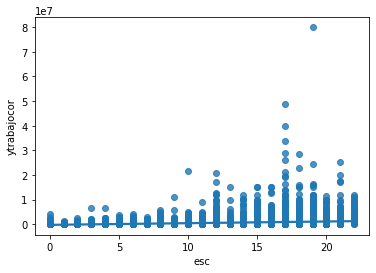

In [16]:
# Años de escolaridad
sns.regplot(x="esc", y="ytrabajocor", data=datos);

#Hay relación entre el segmento de trabajo y escolaridad???

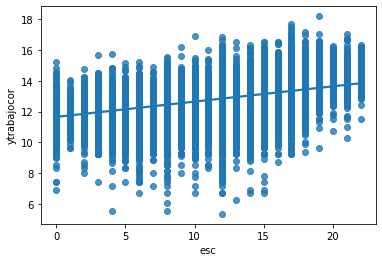

In [17]:
sns.regplot(y= np.log(datos['ytrabajocor']), x=datos['esc'])

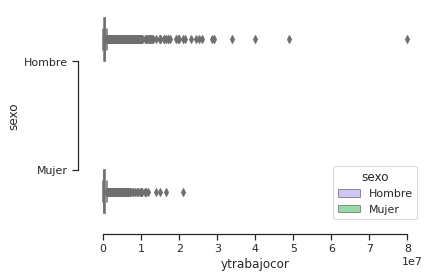

In [18]:
#Cambiamos nuestro tema
sns.set_theme(style="ticks", palette="pastel")

#Profundizamos en nuestros datos y su relación (Sexo y Salario)
sns.boxplot(x="ytrabajocor", y="sexo",
            hue="sexo", palette=["m", "g"],
            data=datos)
sns.despine(offset=10, trim=True)

## FEA visualización debido a los casos extremos (outliers)

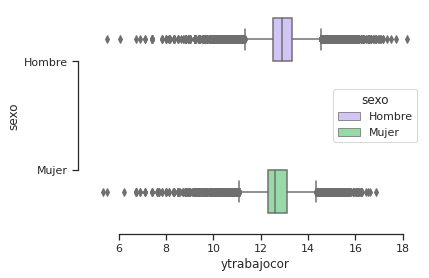

In [19]:
#Cambiamos nuestro tema
sns.set_theme(style="ticks", palette="pastel")

#Profundizamos en nuestros datos y su relación (Sexo y Salario)
sns.boxplot(x=np.log(datos["ytrabajocor"]), y="sexo",
            hue="sexo", palette=["m", "g"],
            data=datos)
sns.despine(offset=10, trim=True)

#Ahora estamos en escala logaritmica

In [20]:
#Estimación del modelo de Regresión Lineal
#Especificamos la formula de nuestro modelo
formula= 'ytrabajocor~edad+esc+C(sexo)+C(oficio1)+C(rama1)+C(zona)'

In [21]:
#Implementamos el modelo
modelo1= smf.ols(formula=formula, data=datos)
#Ajuste del modelo
res= modelo1.fit()
#Resumen del modelo
print(res.summary())

#Cual podría ser el error de nuestro modelo?? error tipo 2


                            OLS Regression Results                            
Dep. Variable:            ytrabajocor   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     758.6
Date:                Fri, 08 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:17:12   Log-Likelihood:            -1.3422e+06
No. Observations:               89955   AIC:                         2.684e+06
Df Residuals:                   89923   BIC:                         2.685e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [22]:
#Obtenemos los valores sin notación cientifica 
print(round(pd.DataFrame(res.params), 2))

                                                            0
Intercept                                          -227353.23
C(sexo)[T.Mujer]                                   -190006.33
C(oficio1)[T.Empleados de oficina]                   38593.06
C(oficio1)[T.Fuerzas Armada]                        263567.39
C(oficio1)[T.Miembros del poder ejecutivo y de ...  712295.67
C(oficio1)[T.Oficiales, operarios y artesanos d...    3763.26
C(oficio1)[T.Operadores de instalaciones y máqu...   21260.85
C(oficio1)[T.Profesionales, científicos e intel...  654742.66
C(oficio1)[T.Sin dato]                               84589.70
C(oficio1)[T.Trabajadores de los servicios y ve...   93150.21
C(oficio1)[T.Trabajadores no calificado]               474.87
C(oficio1)[T.Técnicos profesionales de nivel medi]  182848.99
C(rama1)[T.Administración pública y defensa]         25669.25
C(rama1)[T.Agricultura, ganadería, caza y silvi...  -60970.11
C(rama1)[T.Comercio al por mayor y al por menor]   -190119.54
C(rama1)

In [ ]:
# Lo raro del modelo anterior es que tendremos datos negativos para los segmentos con menor ingreso
# Por ejemplo el sueldo base (minimo que gana una persona es -227.353)
# Esto es raro y podemos cometer errores al momento de presentar nuestros análisis

In [23]:
#Solución: 
# Normalizamos valores (outliers) para modelarlos a una distribución normal 
# La normalización también es conocida como Puntajes Z 
datos['puntaje_Z'] = (datos['ytrabajocor'] - datos['ytrabajocor'].mean())/datos['ytrabajocor'].std(ddof=0)
datos

,ytrabajocor,esc,rama1,oficio1,region,zona,sexo,edad,puntaje_Z
0,250000.0,12.0,Comercio al por mayor y al por menor,Trabajadores no calificado,Región de Tarapacá,Urbano,Mujer,56.0,-0.358557
1,200000.0,7.0,Hogares privados con servicio doméstico,Trabajadores no calificado,Región de Tarapacá,Urbano,Mujer,21.0,-0.419504
2,281750.0,12.0,Hoteles y restaurantes,Trabajadores de los servicios y vendedores de ...,Región de Tarapacá,Urbano,Hombre,24.0,-0.319856
3,311750.0,12.0,Hoteles y restaurantes,Trabajadores de los servicios y vendedores de ...,Región de Tarapacá,Urbano,Hombre,28.0,-0.283287
4,341667.0,15.0,Hogares privados con servicio doméstico,Trabajadores no calificado,Región de Tarapacá,Urbano,Hombre,26.0,-0.246820
...,...,...,...,...,...,...,...,...,...
216428,562500.0,8.0,"Agricultura, ganadería, caza y silvicultura",Agricultores y trabajadores calificados agrope...,Región de Arica y Parinacota,Rural,Hombre,40.0,0.022362
216429,150000.0,8.0,"Otras actividades de servicios comunitarios, s...",Trabajadores no calificado,Región de Arica y Parinacota,Rural,Mujer,40.0,-0.480451
216435,200000.0,4.0,Construcción,Trabajadores no calificado,Región de Arica y Parinacota,Rural,Hombre,64.0,-0.419504
216437,250000.0,3.0,"Agricultura, ganadería, caza y silvicultura",Agricultores y trabajadores calificados agrope...,Región de Arica y Parinacota,Rural,Mujer,60.0,-0.358557


In [ ]:
# Como interpretamos entonces el puntaje Z?? 
# La persona X esta 0.35 puntos de desviación estandar por debajo de la media de los ingresos del trabajo

count    89955.0
mean         0.0
std          1.0
min         -1.0
25%         -0.0
50%         -0.0
75%          0.0
max         97.0
Name: puntaje_Z, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


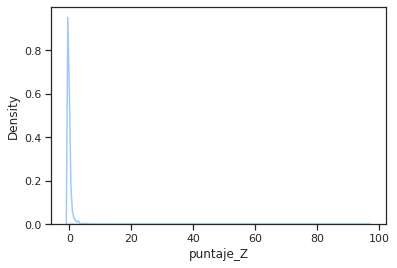

In [24]:
#Hacemos un breve analisis univariado de nuestra muestra Z
print(round(datos['puntaje_Z'].describe(include= all)))

sns.distplot(datos['puntaje_Z'], bins= 1)

count    84353.0
mean        -0.0
std          0.0
min         -1.0
25%         -0.0
50%         -0.0
75%         -0.0
max          1.0
Name: puntaje_Z, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


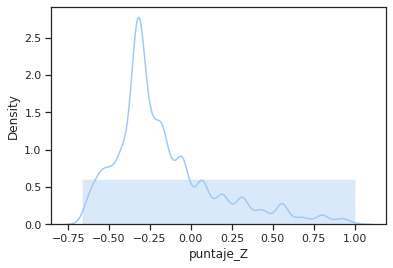

In [25]:
#Crearemos una nueva copia de nuestros datos, pero esta vez filtrando quienes tiene un puntaje Z
# muy alto

#datos1=datos[datos['puntaje_Z']<=10]
datos1=datos[datos['puntaje_Z']<=1]
print(round(datos1['puntaje_Z'].describe(include=all)))
sns.distplot(datos1['puntaje_Z'], bins=1)

In [26]:
#Implementamos nuestro modelo
modelo2= smf.ols(formula=formula, data= datos1)
#Ajustamos el Modelo
res2= modelo2.fit()
#Resumen del modelo
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:            ytrabajocor   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     1473.
Date:                Fri, 08 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:54:33   Log-Likelihood:            -1.1530e+06
No. Observations:               84353   AIC:                         2.306e+06
Df Residuals:                   84321   BIC:                         2.306e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [27]:
print(round(pd.DataFrame(res2.params), 2))

                                                            0
Intercept                                           111724.18
C(sexo)[T.Mujer]                                    -86302.87
C(oficio1)[T.Empleados de oficina]                   70759.34
C(oficio1)[T.Fuerzas Armada]                        200140.72
C(oficio1)[T.Miembros del poder ejecutivo y de ...  150502.13
C(oficio1)[T.Oficiales, operarios y artesanos d...   29377.74
C(oficio1)[T.Operadores de instalaciones y máqu...   73475.67
C(oficio1)[T.Profesionales, científicos e intel...  322102.49
C(oficio1)[T.Sin dato]                               68146.63
C(oficio1)[T.Trabajadores de los servicios y ve...   34548.54
C(oficio1)[T.Trabajadores no calificado]            -14259.14
C(oficio1)[T.Técnicos profesionales de nivel medi]  159034.20
C(rama1)[T.Administración pública y defensa]         89503.19
C(rama1)[T.Agricultura, ganadería, caza y silvi...  -13021.01
C(rama1)[T.Comercio al por mayor y al por menor]    -50278.09
C(rama1)

# Comrpobación de supuestos (StatsModel)

In [28]:
from statsmodels.compat import lzip

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

## Normalidad de los residuos

In [29]:
#Normalidad de los residuos (Shapiro- Wilk)
from scipy import stats
shapiro_test = stats.shapiro(res2.resid)
shapiro_test

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9531173706054688, 0.0)

Interpretación de shapiro-Wilk:
La hipotesis nula (H0) es que los datos se distribuyen de manera nornal, si el p-valor es menor a 0.05 (nvl de significancia) la hipotesis nula es rechazada, por tanto se concluye la distribución de datos no es de una distribución normal 

(como en nuestro caso)

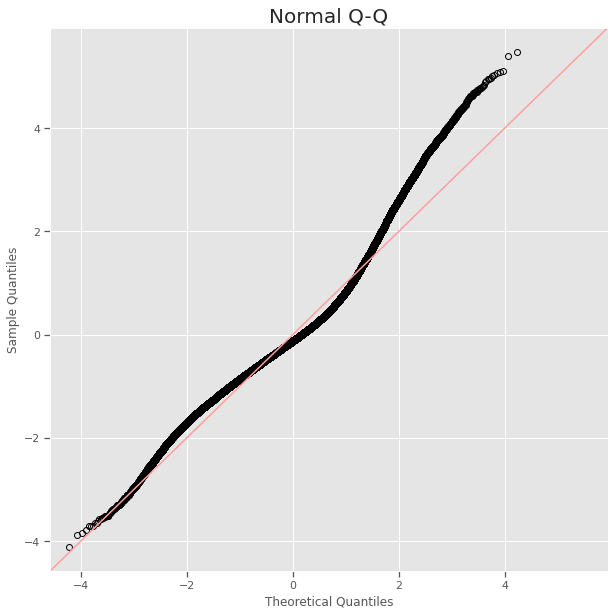

In [30]:
## Normalidad de los residuos
plt.rc('figure', figsize=(10,10))
plt.style.use('ggplot')

probplot = sm.ProbPlot(res2.get_influence().resid_studentized_internal, fit=True)
fig = probplot.qqplot(line='45', marker='o', color='black',mfc='none')
plt.title('Normal Q-Q', fontsize=20)
plt.show()

## Multicolinealidad

In [31]:
# Multicolinealidad (Calcularemos el VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = modelo2.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif

[85.40677549487216,
 1.3945321986383403,
 3.003406061967405,
 1.2169596458955005,
 2.0622786619457885,
 4.641945770760338,
 3.444405192564311,
 3.906405322711442,
 1.1247600125854131,
 4.9133926973378355,
 5.046064670141964,
 3.6869155601393695,
 1.9392555932419537,
 3.5060026872196803,
 3.8985843922088583,
 2.8368632645789553,
 2.4448282610522782,
 1.4632257407952067,
 2.1895205073733055,
 2.014409231071892,
 2.608148098738145,
 1.1775136737373029,
 1.0014313601478086,
 1.5829960973948316,
 1.4233722606695742,
 1.8496646627738509,
 1.2221290491450456,
 1.1616045355280626,
 2.503893927139763,
 1.264120893218629,
 1.2198543505369517,
 1.8516624839567934]

El valor VIF es un resultado que nos explica la multicolinealidad de cada una de las variables, donde las columnas (variables) con un valor mayor a 5 o muy cercanas presentan indicios de multicolinealidad por tanto deben ser eliminadas del modelo o transformadas

Otra forma de ver este supuesto consiste en analizar el mapa de correlaciones para determinar que variables estan fuertemente correlacionadas entre ellas.

## Homocedasticidad

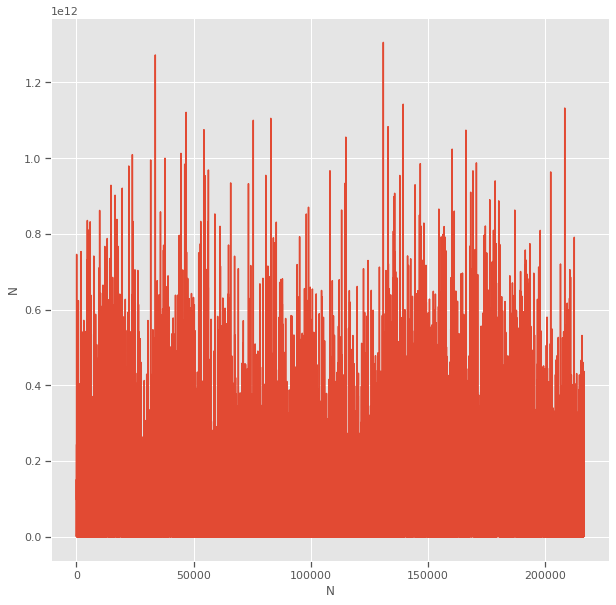

In [32]:
#1 - Homocedasticidad de los residuos (diferencia entre lo estimado y lo real)
# Los residuos se deben distribuir de manera homogenea 
# Analisis visual de la distribución de los errores (no cuadraticos)
plt.figure(1)
#plt.plot(res2.resid)
plt.plot(res2.resid**2)
plt.xlabel('N')
plt.ylabel('N')
plt.grid(True)
plt.show()

In [33]:
# Heterocedasticidad (Test breusch pagan)
breuschpagan_p= sms.het_breuschpagan(res2.resid, res2.model.exog)[1]
print(breuschpagan_p)
if breuschpagan_p> 0.05:
  print("La relación no es heterocedástica")
if breuschpagan_p <0.05:
  print("La relación es heterocedastica")

#El valor p es lo suficientemente pequeño como para rechazar la hipótesis nula de que la varianza de los residuos 
#no depende de los valores de las variables de entrada. Por tanto, se supone que existe heterocedasticidad.

0.0
La relación es heterocedastica


## Linealidad

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

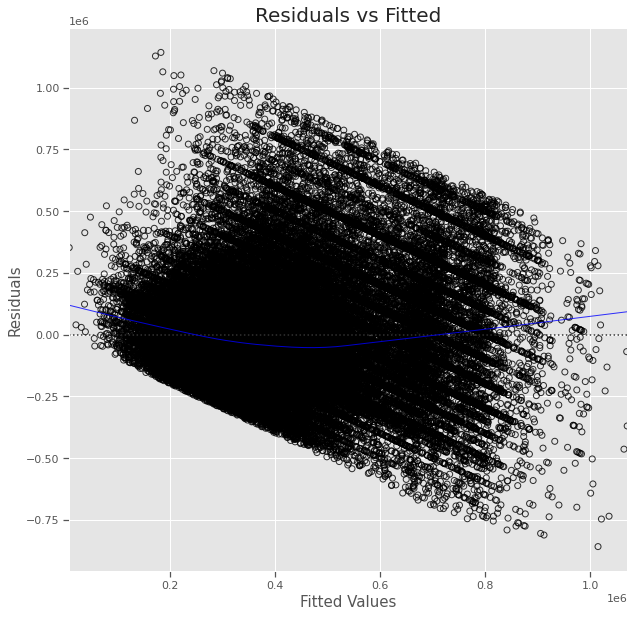

In [34]:
#Linealidad
sns.residplot(res2.fittedvalues, 'ytrabajocor', data=datos1, 
                          lowess=True, 
                          scatter_kws={'facecolors':'none', 'edgecolors':'black'}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})

plt.title('Residuals vs Fitted', fontsize=20)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Residuals', fontsize=15)